In [4]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd
import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


In [5]:

data_dir = 'data'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

0.3%

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




6.0%

100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100.0%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
class Encoder(nn.Module):

	def __init__(self, encoded_space_dim,fc2_input_dim):
		super().__init__()

		### Convolutional section
		self.encoder_cnn = nn.Sequential(
		nn.Conv2d(1, 8, 3, stride=2, padding=1),
		nn.ReLU(True),
		nn.Conv2d(8, 16, 3, stride=2, padding=1),
		nn.BatchNorm2d(16),
		nn.ReLU(True),
		nn.Conv2d(16, 32, 3, stride=2, padding=0),
		nn.ReLU(True)
		)

		### Flatten layer
		self.flatten = nn.Flatten(start_dim=1)
### Linear section
		self.encoder_lin = nn.Sequential(
			nn.Linear(3 * 3 * 32, 128),
			nn.ReLU(True),
			nn.Linear(128, encoded_space_dim)
		)

	def forward(self, x):
		x = self.encoder_cnn(x)
		x = self.flatten(x)
		x = self.encoder_lin(x)
		return x
class Decoder(nn.Module):

	def __init__(self, encoded_space_dim,fc2_input_dim):
		super().__init__()
		self.decoder_lin = nn.Sequential(
			nn.Linear(encoded_space_dim, 128),
			nn.ReLU(True),
			nn.Linear(128, 3 * 3 * 32),
			nn.ReLU(True)
		)

		self.unflatten = nn.Unflatten(dim=1,
		unflattened_size=(32, 3, 3))

		self.decoder_conv = nn.Sequential(
			nn.ConvTranspose2d(32, 16, 3,
			stride=2, output_padding=0),
			nn.BatchNorm2d(16),
			nn.ReLU(True),
			nn.ConvTranspose2d(16, 8, 3, stride=2,
			padding=1, output_padding=1),
			nn.BatchNorm2d(8),
			nn.ReLU(True),
			nn.ConvTranspose2d(8, 1, 3, stride=2,
			padding=1, output_padding=1)
		)

	def forward(self, x):
		x = self.decoder_lin(x)
		x = self.unflatten(x)
		x = self.decoder_conv(x)
		x = torch.sigmoid(x)
		return x

In [7]:
class Encoder(nn.Module):

	def __init__(self, encoded_space_dim,fc2_input_dim):
		super().__init__()

		### Convolutional section
		self.encoder_cnn = nn.Sequential(
		nn.Conv2d(1, 8, 3, stride=2, padding=1),
		nn.ReLU(True),
		nn.Conv2d(8, 16, 3, stride=2, padding=1),
		nn.BatchNorm2d(16),
		nn.ReLU(True),
		nn.Conv2d(16, 32, 3, stride=2, padding=0),
		nn.ReLU(True)
		)

		### Flatten layer
		self.flatten = nn.Flatten(start_dim=1)
### Linear section
		self.encoder_lin = nn.Sequential(
			nn.Linear(3 * 3 * 32, 128),
			nn.ReLU(True),
			nn.Linear(128, encoded_space_dim)
		)

	def forward(self, x):
		x = self.encoder_cnn(x)
		x = self.flatten(x)
		x = self.encoder_lin(x)
		return x
class Decoder(nn.Module):

	def __init__(self, encoded_space_dim,fc2_input_dim):
		super().__init__()
		self.decoder_lin = nn.Sequential(
			nn.Linear(encoded_space_dim, 128),
			nn.ReLU(True),
			nn.Linear(128, 3 * 3 * 32),
			nn.ReLU(True)
		)

		self.unflatten = nn.Unflatten(dim=1,
		unflattened_size=(32, 3, 3))

		self.decoder_conv = nn.Sequential(
			nn.ConvTranspose2d(32, 16, 3,
			stride=2, output_padding=0),
			nn.BatchNorm2d(16),
			nn.ReLU(True),
			nn.ConvTranspose2d(16, 8, 3, stride=2,
			padding=1, output_padding=1),
			nn.BatchNorm2d(8),
			nn.ReLU(True),
			nn.ConvTranspose2d(8, 1, 3, stride=2,
			padding=1, output_padding=1)
		)

	def forward(self, x):
		x = self.decoder_lin(x)
		x = self.unflatten(x)
		x = self.decoder_conv(x)
		x = torch.sigmoid(x)
		return x

In [8]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
	{'params': encoder.parameters()},
	{'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [9]:
def add_noise(inputs,noise_factor=0.3):
	noisy = inputs+torch.randn_like(inputs) * noise_factor
	noisy = torch.clip(noisy,0.,1.)
	return noisy

In [10]:
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
	# Set train mode for both the encoder and the decoder
	encoder.train()
	decoder.train()
	train_loss = []
	# Iterate the dataloader (we do not need the label values, this is unsupervised learning)
	for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
		# Move tensor to the proper device
		image_noisy = add_noise(image_batch,noise_factor)
		image_batch = image_batch.to(device)
		image_noisy = image_noisy.to(device)
		# Encode data
		encoded_data = encoder(image_noisy)
		# Decode data
		decoded_data = decoder(encoded_data)
		# Evaluate loss
		loss = loss_fn(decoded_data, image_batch)
		# Backward pass
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		# Print batch loss
		print('\t partial train loss (single batch): %f' % (loss.data))
		train_loss.append(loss.detach().cpu().numpy())

	return np.mean(train_loss)

In [11]:
def test_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_factor=0.3):
	# Set evaluation mode for encoder and decoder
	encoder.eval()
	decoder.eval()
	with torch.no_grad(): # No need to track the gradients
		# Define the lists to store the outputs for each batch
		conc_out = []
		conc_label = []
		for image_batch, _ in dataloader:
			# Move tensor to the proper device
			image_noisy = add_noise(image_batch,noise_factor)
			image_noisy = image_noisy.to(device)
			# Encode data
			encoded_data = encoder(image_noisy)
			# Decode data
			decoded_data = decoder(encoded_data)
			# Append the network output and the original image to the lists
			conc_out.append(decoded_data.cpu())
			conc_label.append(image_batch.cpu())
		# Create a single tensor with all the values in the lists
		conc_out = torch.cat(conc_out)
		conc_label = torch.cat(conc_label)
		# Evaluate global loss
		val_loss = loss_fn(conc_out, conc_label)
	return val_loss.data

In [12]:
def plot_ae_outputs_den(encoder,decoder,n=10,noise_factor=0.3):
	plt.figure(figsize=(16,4.5))
	targets = test_dataset.targets.numpy()
	t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
	for i in range(n):

		ax = plt.subplot(3,n,i+1)
		img = test_dataset[t_idx[i]][0].unsqueeze(0)
		image_noisy = add_noise(img,noise_factor)
		image_noisy = image_noisy.to(device)

		encoder.eval()
		decoder.eval()

		with torch.no_grad():
			rec_img = decoder(encoder(image_noisy))

		plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)
		if i == n//2:
			ax.set_title('Original images')
		ax = plt.subplot(3, n, i + 1 + n)
		plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)
		if i == n//2:
			ax.set_title('Corrupted images')

		ax = plt.subplot(3, n, i + 1 + n + n)
		plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
		ax.get_xaxis().set_visible(False)
		ax.get_yaxis().set_visible(False)
		if i == n//2:
			ax.set_title('Reconstructed images')
	plt.subplots_adjust(left=0.1,
					bottom=0.1,
					right=0.7,
					top=0.9,
					wspace=0.3,
					hspace=0.3)
	plt.show()

EPOCH 1/30
	 partial train loss (single batch): 0.252959
	 partial train loss (single batch): 0.245958
	 partial train loss (single batch): 0.240604
	 partial train loss (single batch): 0.235767
	 partial train loss (single batch): 0.231413
	 partial train loss (single batch): 0.227752
	 partial train loss (single batch): 0.225308
	 partial train loss (single batch): 0.222482
	 partial train loss (single batch): 0.219694
	 partial train loss (single batch): 0.217751
	 partial train loss (single batch): 0.215344
	 partial train loss (single batch): 0.213368
	 partial train loss (single batch): 0.211343
	 partial train loss (single batch): 0.209393
	 partial train loss (single batch): 0.207596
	 partial train loss (single batch): 0.205585
	 partial train loss (single batch): 0.203839
	 partial train loss (single batch): 0.201748
	 partial train loss (single batch): 0.199636
	 partial train loss (single batch): 0.197767
	 partial train loss (single batch): 0.195735
	 partial train loss (s

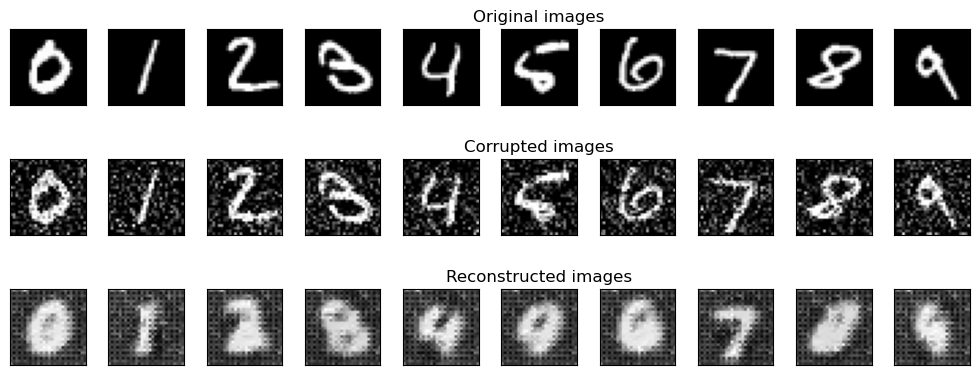

EPOCH 2/30
	 partial train loss (single batch): 0.066884
	 partial train loss (single batch): 0.067214
	 partial train loss (single batch): 0.066763
	 partial train loss (single batch): 0.065433
	 partial train loss (single batch): 0.066337
	 partial train loss (single batch): 0.065798
	 partial train loss (single batch): 0.065804
	 partial train loss (single batch): 0.064909
	 partial train loss (single batch): 0.065524
	 partial train loss (single batch): 0.063981
	 partial train loss (single batch): 0.065809
	 partial train loss (single batch): 0.064173
	 partial train loss (single batch): 0.063505
	 partial train loss (single batch): 0.064071
	 partial train loss (single batch): 0.063019
	 partial train loss (single batch): 0.062919
	 partial train loss (single batch): 0.063438
	 partial train loss (single batch): 0.062846
	 partial train loss (single batch): 0.062961
	 partial train loss (single batch): 0.062845
	 partial train loss (single batch): 0.062007
	 partial train loss (s

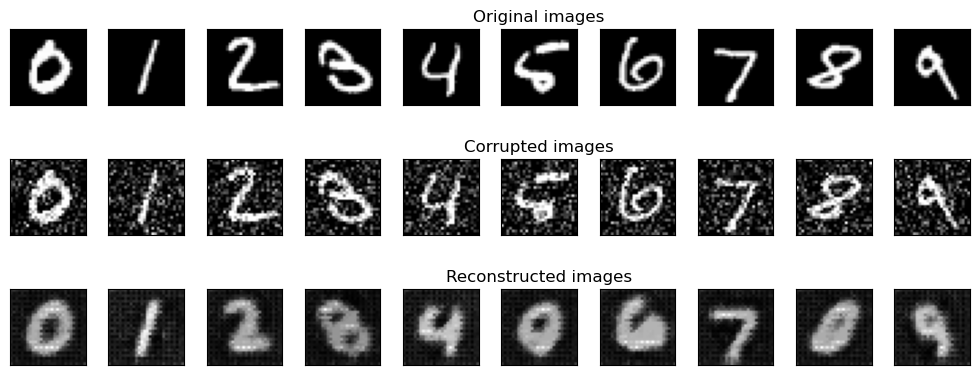

EPOCH 3/30
	 partial train loss (single batch): 0.047602
	 partial train loss (single batch): 0.048501
	 partial train loss (single batch): 0.047950
	 partial train loss (single batch): 0.046552
	 partial train loss (single batch): 0.048184
	 partial train loss (single batch): 0.048082
	 partial train loss (single batch): 0.047811
	 partial train loss (single batch): 0.047196
	 partial train loss (single batch): 0.048095
	 partial train loss (single batch): 0.046291
	 partial train loss (single batch): 0.049071
	 partial train loss (single batch): 0.047270
	 partial train loss (single batch): 0.046538
	 partial train loss (single batch): 0.047370
	 partial train loss (single batch): 0.045806
	 partial train loss (single batch): 0.046181
	 partial train loss (single batch): 0.046473
	 partial train loss (single batch): 0.046519
	 partial train loss (single batch): 0.046734
	 partial train loss (single batch): 0.046675
	 partial train loss (single batch): 0.046174
	 partial train loss (s

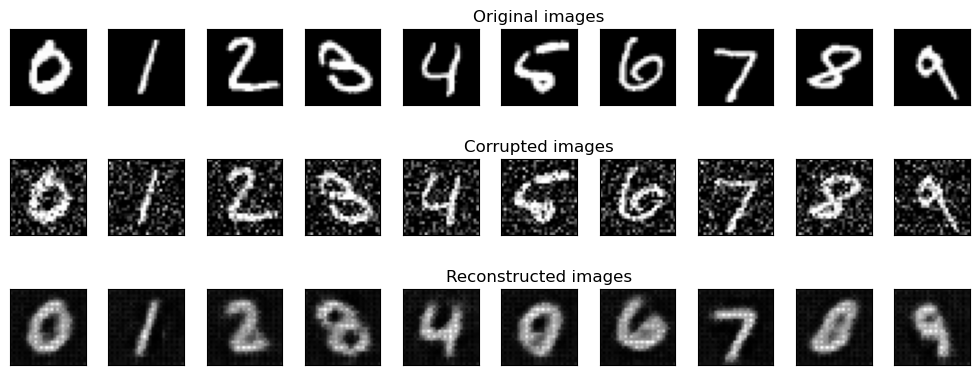

EPOCH 4/30
	 partial train loss (single batch): 0.039355
	 partial train loss (single batch): 0.040804
	 partial train loss (single batch): 0.039091
	 partial train loss (single batch): 0.038871
	 partial train loss (single batch): 0.040719
	 partial train loss (single batch): 0.040396
	 partial train loss (single batch): 0.039761
	 partial train loss (single batch): 0.039461
	 partial train loss (single batch): 0.039680
	 partial train loss (single batch): 0.038557
	 partial train loss (single batch): 0.041141
	 partial train loss (single batch): 0.039499
	 partial train loss (single batch): 0.038628
	 partial train loss (single batch): 0.038525
	 partial train loss (single batch): 0.037472
	 partial train loss (single batch): 0.038269
	 partial train loss (single batch): 0.038385
	 partial train loss (single batch): 0.038407
	 partial train loss (single batch): 0.038474
	 partial train loss (single batch): 0.038586
	 partial train loss (single batch): 0.038325
	 partial train loss (s

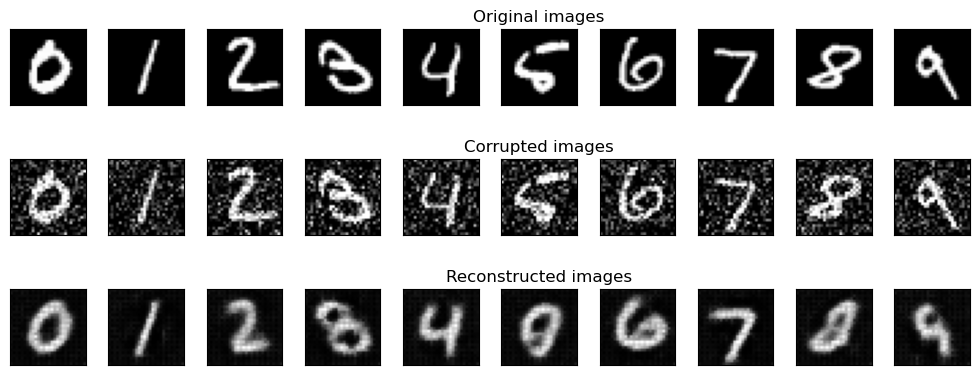

EPOCH 5/30
	 partial train loss (single batch): 0.034392
	 partial train loss (single batch): 0.036064
	 partial train loss (single batch): 0.033900
	 partial train loss (single batch): 0.034359
	 partial train loss (single batch): 0.036455
	 partial train loss (single batch): 0.035812
	 partial train loss (single batch): 0.034994
	 partial train loss (single batch): 0.034946
	 partial train loss (single batch): 0.034777
	 partial train loss (single batch): 0.033650
	 partial train loss (single batch): 0.036312
	 partial train loss (single batch): 0.034667
	 partial train loss (single batch): 0.034007
	 partial train loss (single batch): 0.033647
	 partial train loss (single batch): 0.032889
	 partial train loss (single batch): 0.033697
	 partial train loss (single batch): 0.033428
	 partial train loss (single batch): 0.033864
	 partial train loss (single batch): 0.033752
	 partial train loss (single batch): 0.034387
	 partial train loss (single batch): 0.033964
	 partial train loss (s

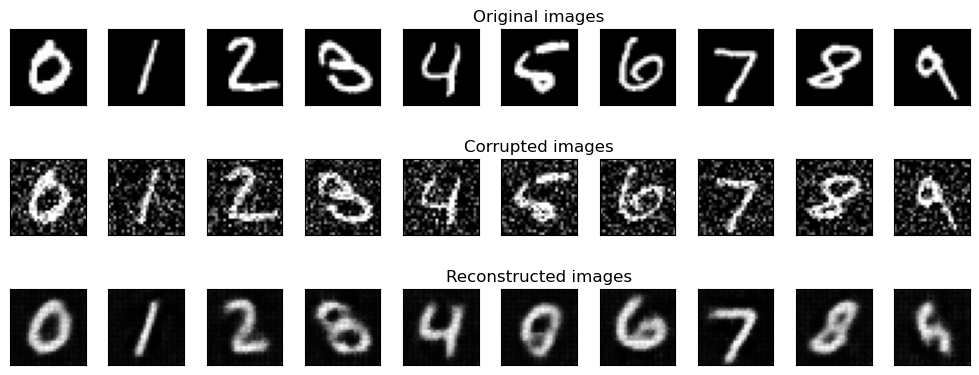

EPOCH 6/30
	 partial train loss (single batch): 0.032239
	 partial train loss (single batch): 0.034031
	 partial train loss (single batch): 0.031760
	 partial train loss (single batch): 0.032332
	 partial train loss (single batch): 0.034560
	 partial train loss (single batch): 0.033617
	 partial train loss (single batch): 0.032706
	 partial train loss (single batch): 0.033348
	 partial train loss (single batch): 0.032733
	 partial train loss (single batch): 0.031484
	 partial train loss (single batch): 0.034153
	 partial train loss (single batch): 0.032629
	 partial train loss (single batch): 0.032040
	 partial train loss (single batch): 0.031386
	 partial train loss (single batch): 0.030941
	 partial train loss (single batch): 0.031999
	 partial train loss (single batch): 0.031318
	 partial train loss (single batch): 0.031821
	 partial train loss (single batch): 0.031639
	 partial train loss (single batch): 0.032360
	 partial train loss (single batch): 0.032166
	 partial train loss (s

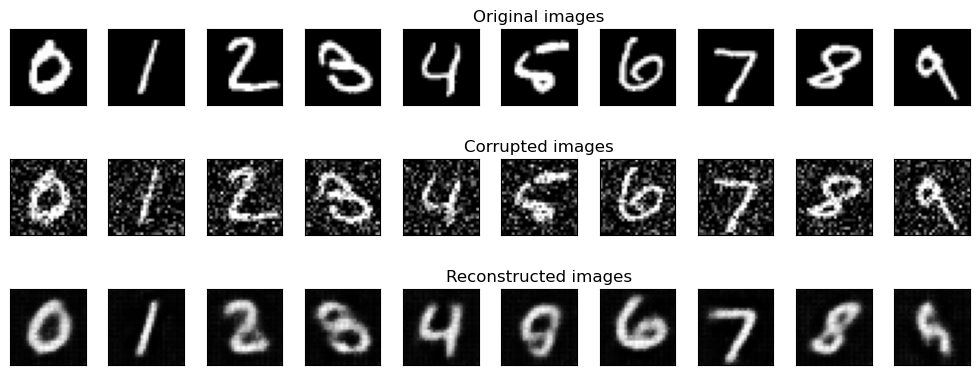

EPOCH 7/30
	 partial train loss (single batch): 0.031204
	 partial train loss (single batch): 0.032759
	 partial train loss (single batch): 0.030511
	 partial train loss (single batch): 0.030943
	 partial train loss (single batch): 0.033314
	 partial train loss (single batch): 0.032386
	 partial train loss (single batch): 0.031454
	 partial train loss (single batch): 0.032101
	 partial train loss (single batch): 0.031778
	 partial train loss (single batch): 0.030494
	 partial train loss (single batch): 0.032829
	 partial train loss (single batch): 0.031157
	 partial train loss (single batch): 0.030716
	 partial train loss (single batch): 0.030004
	 partial train loss (single batch): 0.029682
	 partial train loss (single batch): 0.030639
	 partial train loss (single batch): 0.030084
	 partial train loss (single batch): 0.030934
	 partial train loss (single batch): 0.030499
	 partial train loss (single batch): 0.031186
	 partial train loss (single batch): 0.031112
	 partial train loss (s

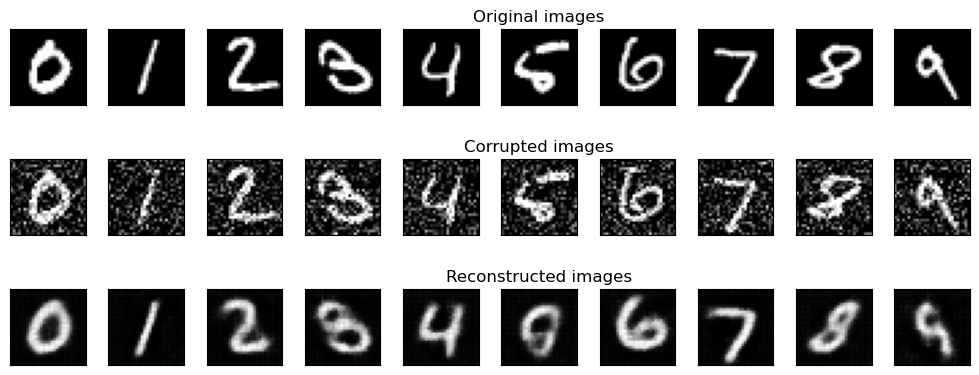

EPOCH 8/30
	 partial train loss (single batch): 0.030413
	 partial train loss (single batch): 0.031941
	 partial train loss (single batch): 0.029975
	 partial train loss (single batch): 0.030313
	 partial train loss (single batch): 0.032564
	 partial train loss (single batch): 0.031375
	 partial train loss (single batch): 0.030614
	 partial train loss (single batch): 0.031315
	 partial train loss (single batch): 0.031007
	 partial train loss (single batch): 0.029656
	 partial train loss (single batch): 0.032061
	 partial train loss (single batch): 0.030421
	 partial train loss (single batch): 0.030029
	 partial train loss (single batch): 0.029044
	 partial train loss (single batch): 0.028804
	 partial train loss (single batch): 0.030098
	 partial train loss (single batch): 0.029420
	 partial train loss (single batch): 0.030100
	 partial train loss (single batch): 0.029507
	 partial train loss (single batch): 0.030265
	 partial train loss (single batch): 0.030340
	 partial train loss (s

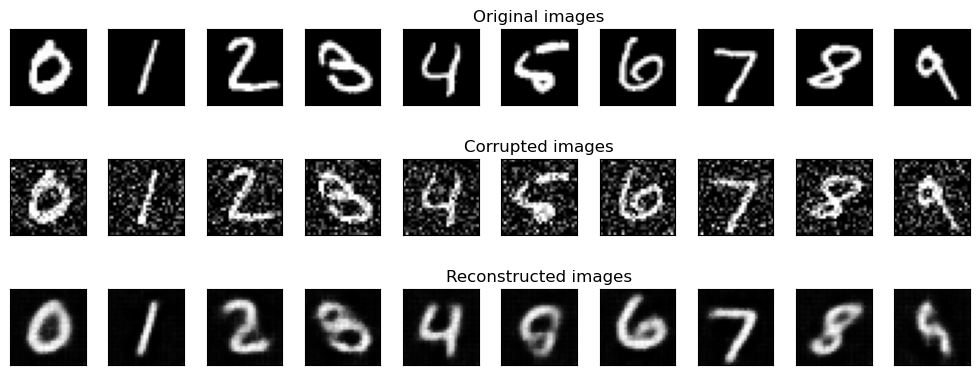

EPOCH 9/30
	 partial train loss (single batch): 0.030325
	 partial train loss (single batch): 0.031420
	 partial train loss (single batch): 0.029260
	 partial train loss (single batch): 0.029928
	 partial train loss (single batch): 0.032050
	 partial train loss (single batch): 0.030701
	 partial train loss (single batch): 0.029984
	 partial train loss (single batch): 0.030826
	 partial train loss (single batch): 0.030555
	 partial train loss (single batch): 0.029271
	 partial train loss (single batch): 0.031663
	 partial train loss (single batch): 0.029973
	 partial train loss (single batch): 0.029421
	 partial train loss (single batch): 0.028579
	 partial train loss (single batch): 0.028574
	 partial train loss (single batch): 0.029782
	 partial train loss (single batch): 0.028991
	 partial train loss (single batch): 0.029567
	 partial train loss (single batch): 0.029007
	 partial train loss (single batch): 0.029773
	 partial train loss (single batch): 0.029858
	 partial train loss (s

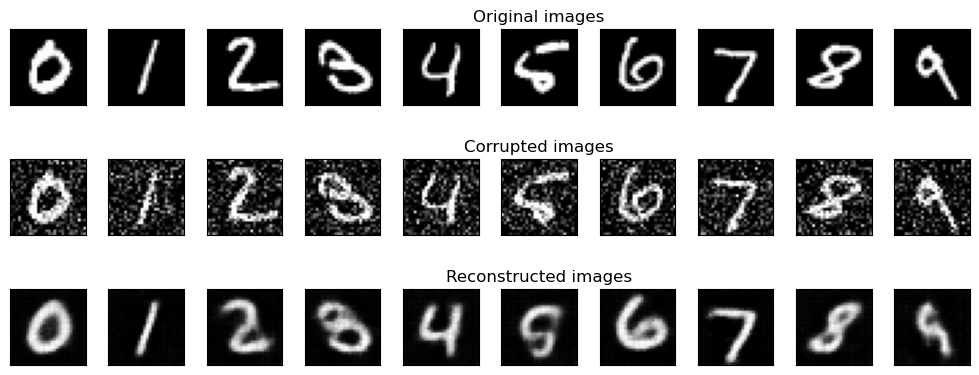

EPOCH 10/30
	 partial train loss (single batch): 0.029752
	 partial train loss (single batch): 0.030867
	 partial train loss (single batch): 0.028936
	 partial train loss (single batch): 0.029658
	 partial train loss (single batch): 0.031813
	 partial train loss (single batch): 0.030471
	 partial train loss (single batch): 0.029823
	 partial train loss (single batch): 0.030831
	 partial train loss (single batch): 0.030001
	 partial train loss (single batch): 0.029183
	 partial train loss (single batch): 0.031420
	 partial train loss (single batch): 0.029830
	 partial train loss (single batch): 0.029263
	 partial train loss (single batch): 0.028366
	 partial train loss (single batch): 0.028079
	 partial train loss (single batch): 0.029512
	 partial train loss (single batch): 0.028645
	 partial train loss (single batch): 0.029145
	 partial train loss (single batch): 0.028677
	 partial train loss (single batch): 0.029381
	 partial train loss (single batch): 0.029546
	 partial train loss (

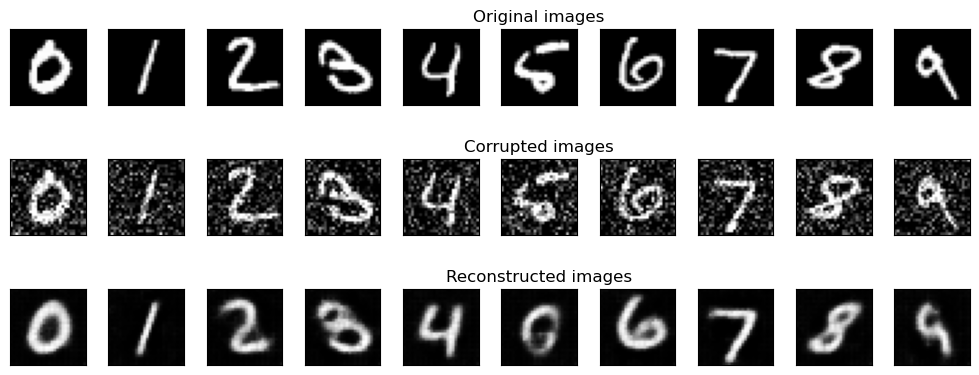

EPOCH 11/30
	 partial train loss (single batch): 0.029355
	 partial train loss (single batch): 0.030808
	 partial train loss (single batch): 0.028790
	 partial train loss (single batch): 0.029214
	 partial train loss (single batch): 0.031374
	 partial train loss (single batch): 0.029912
	 partial train loss (single batch): 0.029078
	 partial train loss (single batch): 0.030253
	 partial train loss (single batch): 0.029692
	 partial train loss (single batch): 0.028895
	 partial train loss (single batch): 0.030942
	 partial train loss (single batch): 0.029385
	 partial train loss (single batch): 0.028750
	 partial train loss (single batch): 0.027701
	 partial train loss (single batch): 0.027731
	 partial train loss (single batch): 0.028902
	 partial train loss (single batch): 0.028322
	 partial train loss (single batch): 0.029001
	 partial train loss (single batch): 0.028249
	 partial train loss (single batch): 0.028980
	 partial train loss (single batch): 0.029333
	 partial train loss (

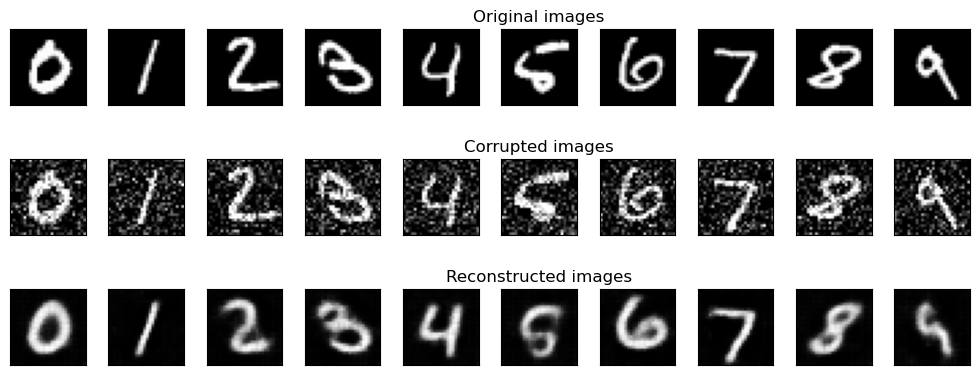

EPOCH 12/30
	 partial train loss (single batch): 0.029010
	 partial train loss (single batch): 0.030546
	 partial train loss (single batch): 0.028204
	 partial train loss (single batch): 0.029180
	 partial train loss (single batch): 0.031239
	 partial train loss (single batch): 0.029498
	 partial train loss (single batch): 0.028794
	 partial train loss (single batch): 0.029973
	 partial train loss (single batch): 0.029409
	 partial train loss (single batch): 0.028610
	 partial train loss (single batch): 0.030730
	 partial train loss (single batch): 0.029025
	 partial train loss (single batch): 0.028553
	 partial train loss (single batch): 0.027421
	 partial train loss (single batch): 0.027738
	 partial train loss (single batch): 0.028308
	 partial train loss (single batch): 0.028130
	 partial train loss (single batch): 0.028666
	 partial train loss (single batch): 0.027901
	 partial train loss (single batch): 0.028548
	 partial train loss (single batch): 0.028841
	 partial train loss (

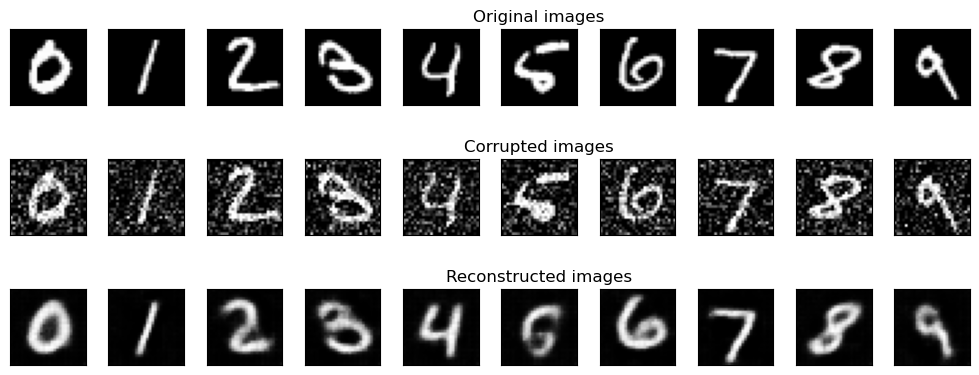

EPOCH 13/30
	 partial train loss (single batch): 0.028664
	 partial train loss (single batch): 0.030284
	 partial train loss (single batch): 0.028130
	 partial train loss (single batch): 0.028783
	 partial train loss (single batch): 0.031077
	 partial train loss (single batch): 0.029150
	 partial train loss (single batch): 0.028585
	 partial train loss (single batch): 0.029735
	 partial train loss (single batch): 0.029208
	 partial train loss (single batch): 0.028207
	 partial train loss (single batch): 0.030598
	 partial train loss (single batch): 0.028865
	 partial train loss (single batch): 0.028160
	 partial train loss (single batch): 0.027377
	 partial train loss (single batch): 0.027180
	 partial train loss (single batch): 0.028237
	 partial train loss (single batch): 0.027906
	 partial train loss (single batch): 0.028874
	 partial train loss (single batch): 0.027563
	 partial train loss (single batch): 0.028606
	 partial train loss (single batch): 0.028626
	 partial train loss (

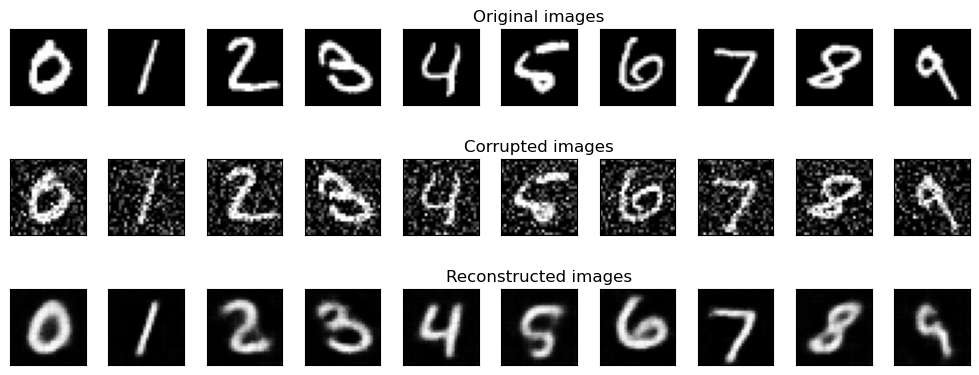

EPOCH 14/30
	 partial train loss (single batch): 0.028211
	 partial train loss (single batch): 0.029902
	 partial train loss (single batch): 0.027448
	 partial train loss (single batch): 0.028719
	 partial train loss (single batch): 0.030567
	 partial train loss (single batch): 0.028863
	 partial train loss (single batch): 0.028255
	 partial train loss (single batch): 0.029475
	 partial train loss (single batch): 0.029010
	 partial train loss (single batch): 0.028083
	 partial train loss (single batch): 0.030293
	 partial train loss (single batch): 0.028741
	 partial train loss (single batch): 0.027732
	 partial train loss (single batch): 0.027197
	 partial train loss (single batch): 0.026932
	 partial train loss (single batch): 0.027852
	 partial train loss (single batch): 0.027457
	 partial train loss (single batch): 0.028325
	 partial train loss (single batch): 0.027477
	 partial train loss (single batch): 0.028290
	 partial train loss (single batch): 0.028674
	 partial train loss (

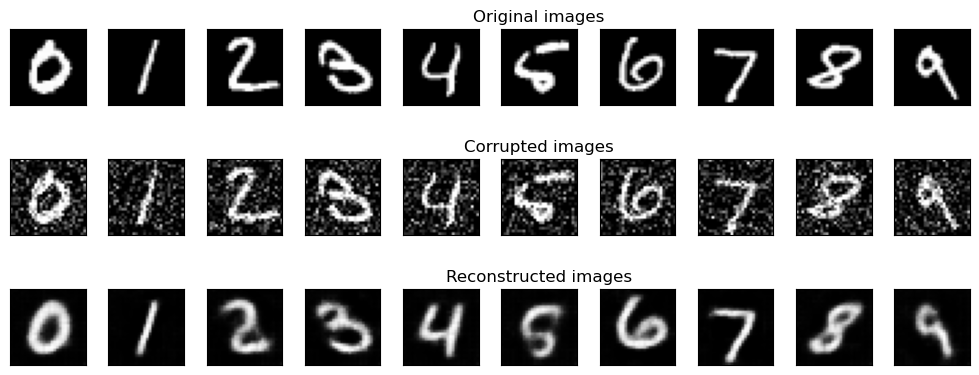

EPOCH 15/30
	 partial train loss (single batch): 0.028295
	 partial train loss (single batch): 0.029888
	 partial train loss (single batch): 0.027431
	 partial train loss (single batch): 0.028621
	 partial train loss (single batch): 0.030420
	 partial train loss (single batch): 0.028523
	 partial train loss (single batch): 0.028134
	 partial train loss (single batch): 0.029287
	 partial train loss (single batch): 0.028789
	 partial train loss (single batch): 0.027853
	 partial train loss (single batch): 0.030140
	 partial train loss (single batch): 0.028429
	 partial train loss (single batch): 0.027692
	 partial train loss (single batch): 0.026927
	 partial train loss (single batch): 0.027048
	 partial train loss (single batch): 0.027867
	 partial train loss (single batch): 0.027265
	 partial train loss (single batch): 0.028214
	 partial train loss (single batch): 0.027469
	 partial train loss (single batch): 0.027938
	 partial train loss (single batch): 0.028272
	 partial train loss (

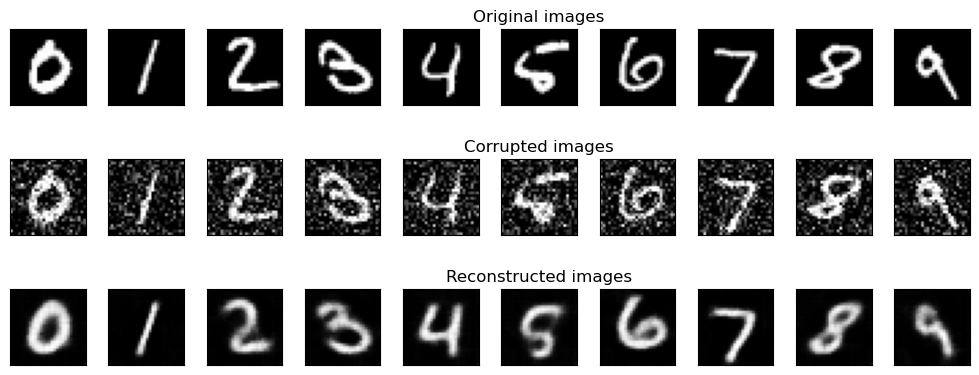

EPOCH 16/30
	 partial train loss (single batch): 0.028346
	 partial train loss (single batch): 0.029556
	 partial train loss (single batch): 0.027180
	 partial train loss (single batch): 0.028331
	 partial train loss (single batch): 0.030279
	 partial train loss (single batch): 0.028558
	 partial train loss (single batch): 0.028199
	 partial train loss (single batch): 0.029149
	 partial train loss (single batch): 0.028760
	 partial train loss (single batch): 0.027620
	 partial train loss (single batch): 0.030273
	 partial train loss (single batch): 0.028188
	 partial train loss (single batch): 0.027747
	 partial train loss (single batch): 0.026792
	 partial train loss (single batch): 0.026838
	 partial train loss (single batch): 0.027774
	 partial train loss (single batch): 0.027293
	 partial train loss (single batch): 0.028127
	 partial train loss (single batch): 0.027349
	 partial train loss (single batch): 0.027791
	 partial train loss (single batch): 0.028161
	 partial train loss (

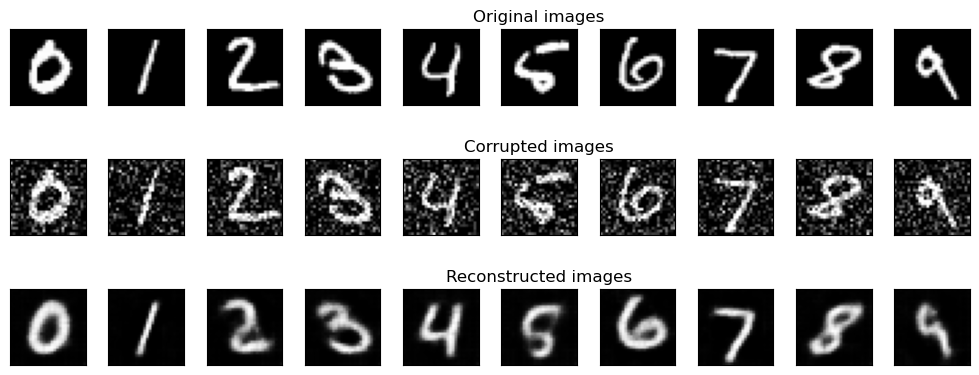

EPOCH 17/30
	 partial train loss (single batch): 0.028062
	 partial train loss (single batch): 0.029467
	 partial train loss (single batch): 0.027002
	 partial train loss (single batch): 0.028292
	 partial train loss (single batch): 0.029946
	 partial train loss (single batch): 0.028587
	 partial train loss (single batch): 0.027828
	 partial train loss (single batch): 0.028859
	 partial train loss (single batch): 0.028411
	 partial train loss (single batch): 0.027623
	 partial train loss (single batch): 0.029806
	 partial train loss (single batch): 0.028205
	 partial train loss (single batch): 0.027406
	 partial train loss (single batch): 0.026659
	 partial train loss (single batch): 0.026715
	 partial train loss (single batch): 0.027628
	 partial train loss (single batch): 0.027160
	 partial train loss (single batch): 0.028186
	 partial train loss (single batch): 0.026949
	 partial train loss (single batch): 0.027897
	 partial train loss (single batch): 0.028145
	 partial train loss (

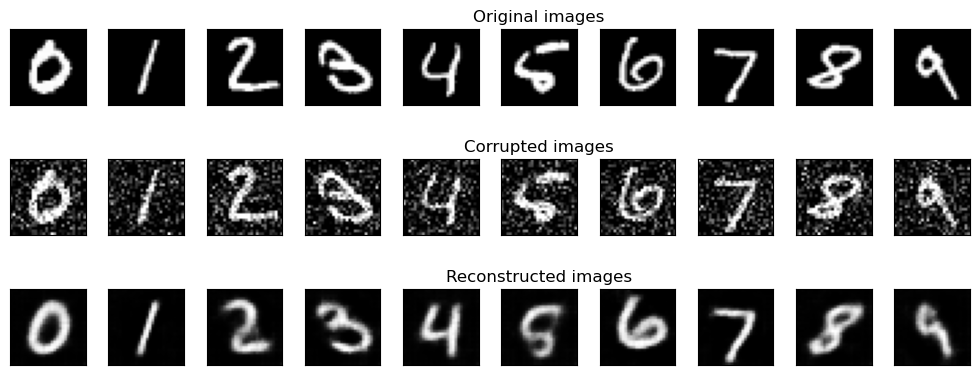

EPOCH 18/30
	 partial train loss (single batch): 0.027747
	 partial train loss (single batch): 0.029328
	 partial train loss (single batch): 0.026926
	 partial train loss (single batch): 0.028053
	 partial train loss (single batch): 0.029997
	 partial train loss (single batch): 0.028232
	 partial train loss (single batch): 0.027896
	 partial train loss (single batch): 0.028891
	 partial train loss (single batch): 0.028396
	 partial train loss (single batch): 0.027452
	 partial train loss (single batch): 0.029869
	 partial train loss (single batch): 0.028028
	 partial train loss (single batch): 0.027105
	 partial train loss (single batch): 0.026303
	 partial train loss (single batch): 0.026700
	 partial train loss (single batch): 0.027437
	 partial train loss (single batch): 0.026912
	 partial train loss (single batch): 0.027885
	 partial train loss (single batch): 0.027103
	 partial train loss (single batch): 0.027772
	 partial train loss (single batch): 0.027850
	 partial train loss (

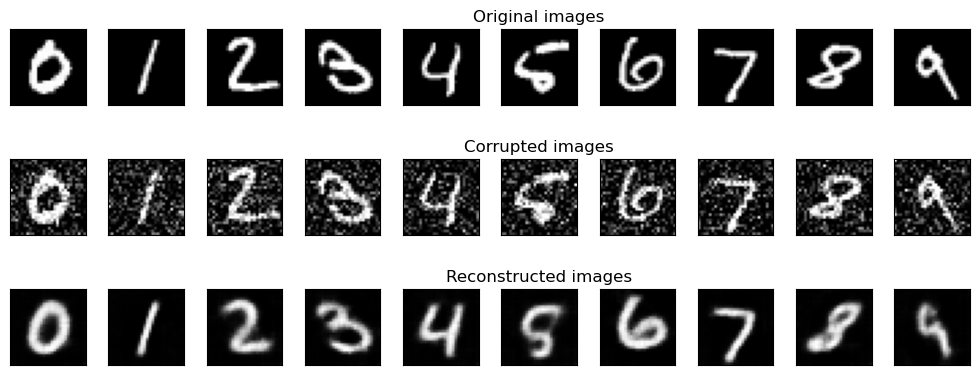

EPOCH 19/30
	 partial train loss (single batch): 0.027776
	 partial train loss (single batch): 0.029081
	 partial train loss (single batch): 0.026871
	 partial train loss (single batch): 0.027898
	 partial train loss (single batch): 0.029923
	 partial train loss (single batch): 0.028184
	 partial train loss (single batch): 0.027630
	 partial train loss (single batch): 0.028903
	 partial train loss (single batch): 0.028329
	 partial train loss (single batch): 0.027402
	 partial train loss (single batch): 0.030142
	 partial train loss (single batch): 0.028121
	 partial train loss (single batch): 0.027351
	 partial train loss (single batch): 0.026299
	 partial train loss (single batch): 0.026485
	 partial train loss (single batch): 0.027361
	 partial train loss (single batch): 0.026877
	 partial train loss (single batch): 0.027866
	 partial train loss (single batch): 0.027041
	 partial train loss (single batch): 0.027632
	 partial train loss (single batch): 0.027746
	 partial train loss (

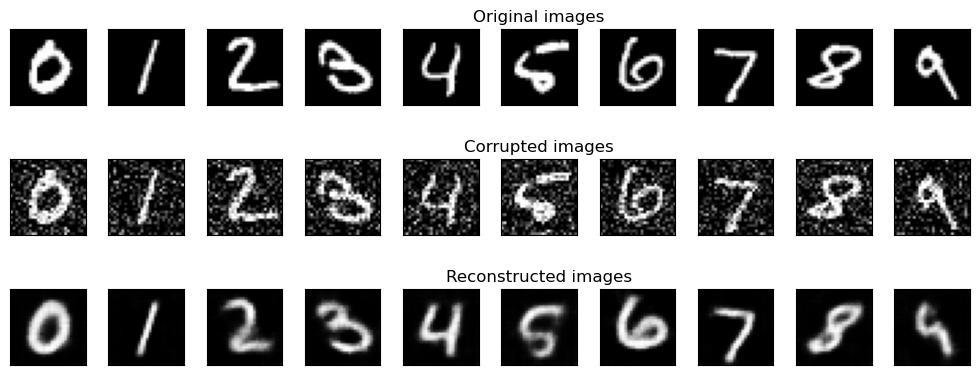

EPOCH 20/30
	 partial train loss (single batch): 0.027332
	 partial train loss (single batch): 0.029047
	 partial train loss (single batch): 0.026347
	 partial train loss (single batch): 0.027510
	 partial train loss (single batch): 0.029620
	 partial train loss (single batch): 0.027834
	 partial train loss (single batch): 0.027693
	 partial train loss (single batch): 0.028331
	 partial train loss (single batch): 0.028270
	 partial train loss (single batch): 0.027254
	 partial train loss (single batch): 0.029598
	 partial train loss (single batch): 0.027591
	 partial train loss (single batch): 0.027015
	 partial train loss (single batch): 0.026242
	 partial train loss (single batch): 0.026237
	 partial train loss (single batch): 0.027336
	 partial train loss (single batch): 0.026676
	 partial train loss (single batch): 0.027776
	 partial train loss (single batch): 0.026670
	 partial train loss (single batch): 0.027707
	 partial train loss (single batch): 0.027636
	 partial train loss (

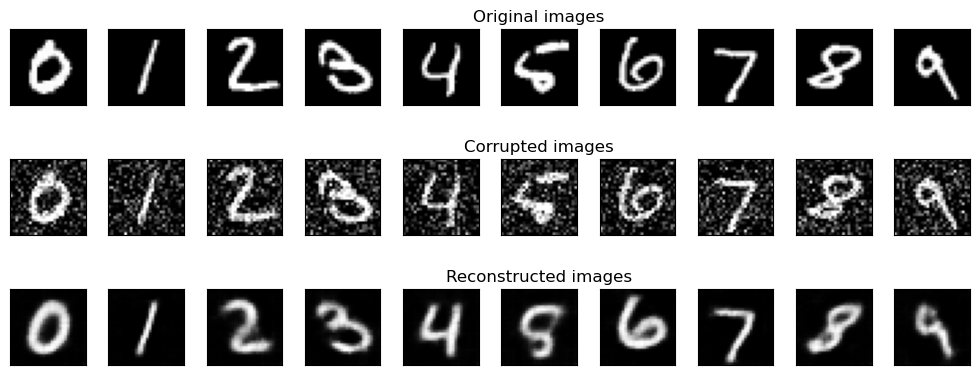

EPOCH 21/30
	 partial train loss (single batch): 0.027413
	 partial train loss (single batch): 0.028934
	 partial train loss (single batch): 0.026367
	 partial train loss (single batch): 0.027688
	 partial train loss (single batch): 0.029411
	 partial train loss (single batch): 0.027862
	 partial train loss (single batch): 0.027418
	 partial train loss (single batch): 0.028393
	 partial train loss (single batch): 0.027963
	 partial train loss (single batch): 0.027123
	 partial train loss (single batch): 0.029459
	 partial train loss (single batch): 0.027622
	 partial train loss (single batch): 0.026823
	 partial train loss (single batch): 0.026165
	 partial train loss (single batch): 0.026272
	 partial train loss (single batch): 0.027178
	 partial train loss (single batch): 0.026893
	 partial train loss (single batch): 0.027698
	 partial train loss (single batch): 0.026551
	 partial train loss (single batch): 0.027464
	 partial train loss (single batch): 0.027526
	 partial train loss (

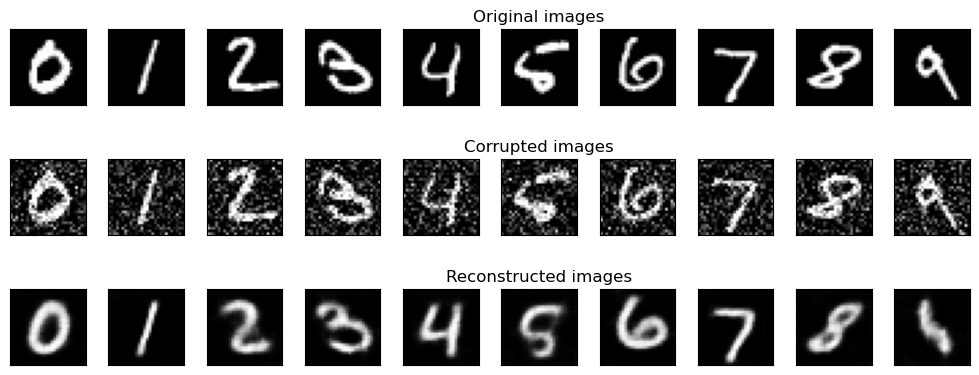

EPOCH 22/30
	 partial train loss (single batch): 0.027471
	 partial train loss (single batch): 0.028980
	 partial train loss (single batch): 0.026570
	 partial train loss (single batch): 0.027627
	 partial train loss (single batch): 0.029350
	 partial train loss (single batch): 0.027845
	 partial train loss (single batch): 0.027432
	 partial train loss (single batch): 0.028423
	 partial train loss (single batch): 0.027932
	 partial train loss (single batch): 0.026830
	 partial train loss (single batch): 0.029578
	 partial train loss (single batch): 0.027355
	 partial train loss (single batch): 0.026929
	 partial train loss (single batch): 0.026058
	 partial train loss (single batch): 0.026171
	 partial train loss (single batch): 0.026935
	 partial train loss (single batch): 0.026746
	 partial train loss (single batch): 0.027813
	 partial train loss (single batch): 0.026812
	 partial train loss (single batch): 0.027576
	 partial train loss (single batch): 0.027531
	 partial train loss (

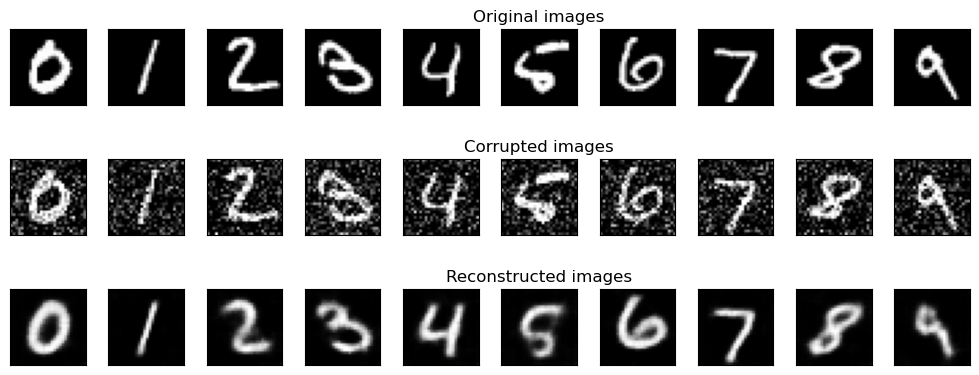

EPOCH 23/30
	 partial train loss (single batch): 0.027355
	 partial train loss (single batch): 0.028901
	 partial train loss (single batch): 0.026183
	 partial train loss (single batch): 0.027546
	 partial train loss (single batch): 0.029231
	 partial train loss (single batch): 0.027784
	 partial train loss (single batch): 0.027393
	 partial train loss (single batch): 0.028083
	 partial train loss (single batch): 0.027944
	 partial train loss (single batch): 0.026880
	 partial train loss (single batch): 0.029324
	 partial train loss (single batch): 0.027662
	 partial train loss (single batch): 0.026903
	 partial train loss (single batch): 0.025842
	 partial train loss (single batch): 0.025866
	 partial train loss (single batch): 0.027127
	 partial train loss (single batch): 0.026464
	 partial train loss (single batch): 0.027621
	 partial train loss (single batch): 0.026614
	 partial train loss (single batch): 0.027165
	 partial train loss (single batch): 0.027355
	 partial train loss (

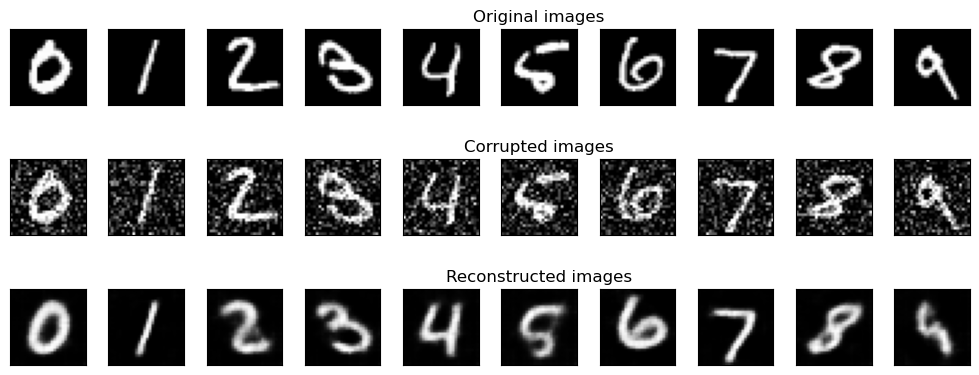

EPOCH 24/30
	 partial train loss (single batch): 0.027254
	 partial train loss (single batch): 0.028736
	 partial train loss (single batch): 0.025961
	 partial train loss (single batch): 0.027407
	 partial train loss (single batch): 0.029490
	 partial train loss (single batch): 0.027744
	 partial train loss (single batch): 0.027217
	 partial train loss (single batch): 0.028455
	 partial train loss (single batch): 0.027840
	 partial train loss (single batch): 0.026836
	 partial train loss (single batch): 0.029531
	 partial train loss (single batch): 0.027750
	 partial train loss (single batch): 0.026716
	 partial train loss (single batch): 0.025825
	 partial train loss (single batch): 0.025923
	 partial train loss (single batch): 0.026952
	 partial train loss (single batch): 0.026550
	 partial train loss (single batch): 0.027535
	 partial train loss (single batch): 0.026648
	 partial train loss (single batch): 0.027524
	 partial train loss (single batch): 0.027247
	 partial train loss (

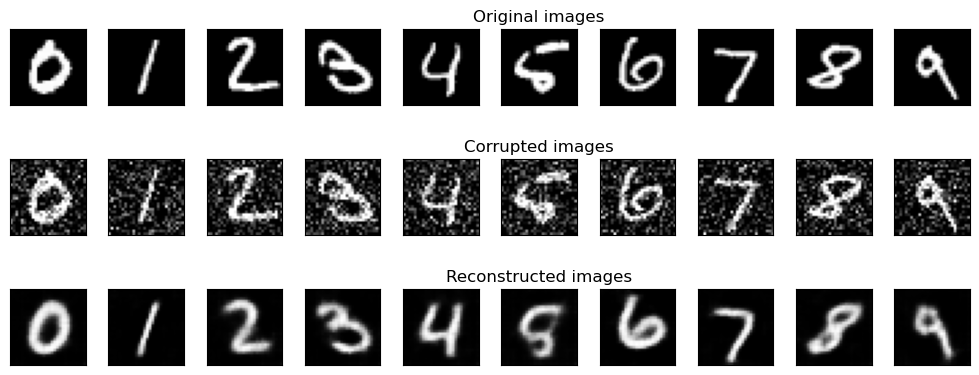

EPOCH 25/30
	 partial train loss (single batch): 0.027312
	 partial train loss (single batch): 0.028754
	 partial train loss (single batch): 0.026086
	 partial train loss (single batch): 0.027349
	 partial train loss (single batch): 0.029313
	 partial train loss (single batch): 0.027557
	 partial train loss (single batch): 0.027151
	 partial train loss (single batch): 0.028146
	 partial train loss (single batch): 0.027665
	 partial train loss (single batch): 0.026752
	 partial train loss (single batch): 0.029297
	 partial train loss (single batch): 0.027666
	 partial train loss (single batch): 0.026582
	 partial train loss (single batch): 0.025711
	 partial train loss (single batch): 0.026076
	 partial train loss (single batch): 0.026787
	 partial train loss (single batch): 0.026161
	 partial train loss (single batch): 0.027672
	 partial train loss (single batch): 0.026515
	 partial train loss (single batch): 0.027143
	 partial train loss (single batch): 0.027365
	 partial train loss (

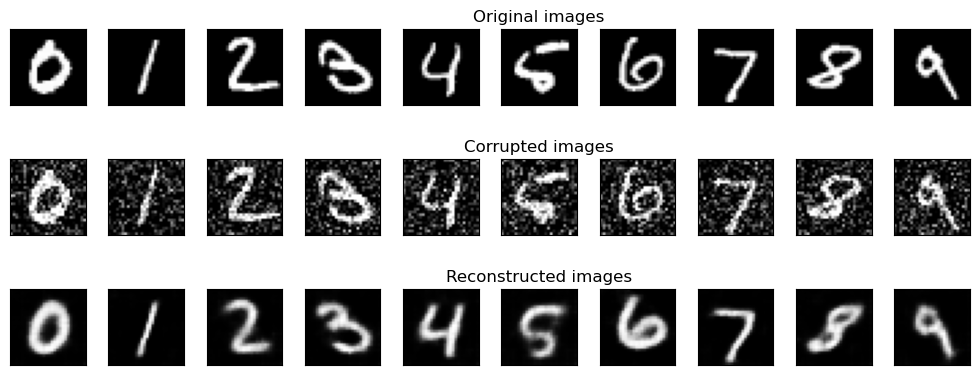

EPOCH 26/30
	 partial train loss (single batch): 0.027084
	 partial train loss (single batch): 0.028666
	 partial train loss (single batch): 0.025835
	 partial train loss (single batch): 0.027366
	 partial train loss (single batch): 0.029165
	 partial train loss (single batch): 0.027483
	 partial train loss (single batch): 0.026968
	 partial train loss (single batch): 0.028060
	 partial train loss (single batch): 0.027789
	 partial train loss (single batch): 0.026631
	 partial train loss (single batch): 0.029125
	 partial train loss (single batch): 0.027242
	 partial train loss (single batch): 0.026350
	 partial train loss (single batch): 0.025696
	 partial train loss (single batch): 0.026168
	 partial train loss (single batch): 0.026787
	 partial train loss (single batch): 0.026352
	 partial train loss (single batch): 0.027751
	 partial train loss (single batch): 0.026580
	 partial train loss (single batch): 0.027310
	 partial train loss (single batch): 0.027278
	 partial train loss (

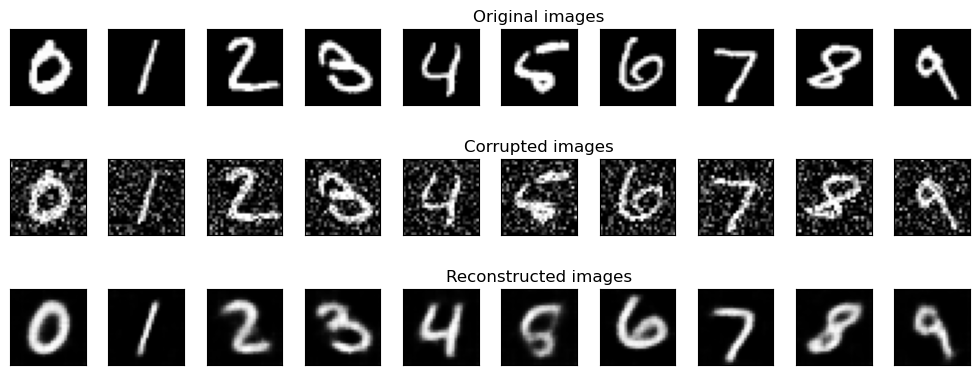

EPOCH 27/30
	 partial train loss (single batch): 0.027010
	 partial train loss (single batch): 0.028267
	 partial train loss (single batch): 0.026143
	 partial train loss (single batch): 0.027161
	 partial train loss (single batch): 0.028953
	 partial train loss (single batch): 0.027653
	 partial train loss (single batch): 0.027089
	 partial train loss (single batch): 0.027910
	 partial train loss (single batch): 0.027743
	 partial train loss (single batch): 0.026314
	 partial train loss (single batch): 0.029200
	 partial train loss (single batch): 0.027363
	 partial train loss (single batch): 0.026456
	 partial train loss (single batch): 0.025756
	 partial train loss (single batch): 0.025708
	 partial train loss (single batch): 0.026705
	 partial train loss (single batch): 0.026235
	 partial train loss (single batch): 0.027272
	 partial train loss (single batch): 0.026454
	 partial train loss (single batch): 0.027292
	 partial train loss (single batch): 0.026927
	 partial train loss (

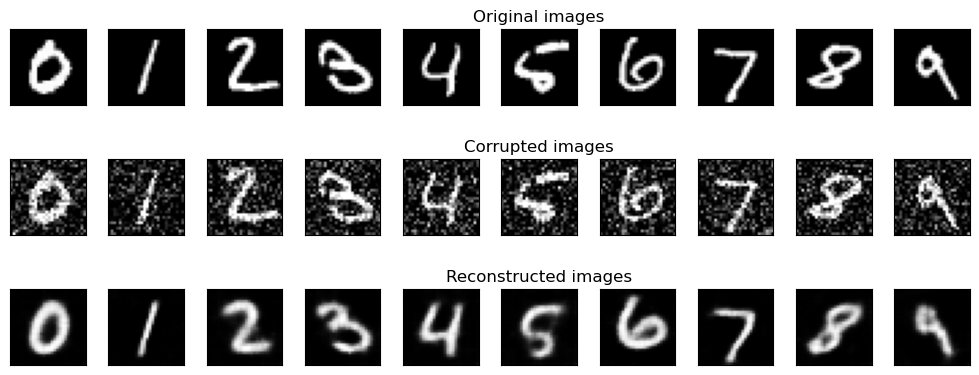

EPOCH 28/30
	 partial train loss (single batch): 0.026805
	 partial train loss (single batch): 0.028532
	 partial train loss (single batch): 0.025853
	 partial train loss (single batch): 0.027180
	 partial train loss (single batch): 0.028864
	 partial train loss (single batch): 0.027326
	 partial train loss (single batch): 0.026816
	 partial train loss (single batch): 0.027933
	 partial train loss (single batch): 0.027809
	 partial train loss (single batch): 0.026281
	 partial train loss (single batch): 0.029108
	 partial train loss (single batch): 0.027263
	 partial train loss (single batch): 0.026329
	 partial train loss (single batch): 0.025673
	 partial train loss (single batch): 0.025543
	 partial train loss (single batch): 0.026598
	 partial train loss (single batch): 0.026176
	 partial train loss (single batch): 0.027401
	 partial train loss (single batch): 0.026332
	 partial train loss (single batch): 0.027208
	 partial train loss (single batch): 0.027082
	 partial train loss (

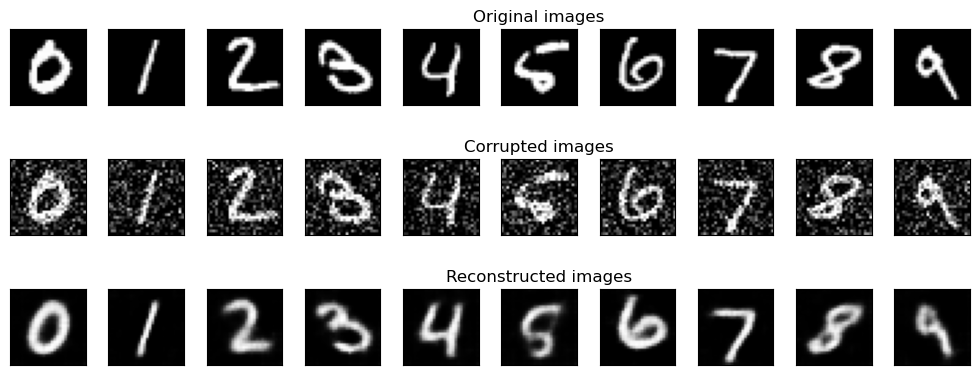

EPOCH 29/30
	 partial train loss (single batch): 0.026805
	 partial train loss (single batch): 0.028435
	 partial train loss (single batch): 0.025599
	 partial train loss (single batch): 0.027155
	 partial train loss (single batch): 0.028788
	 partial train loss (single batch): 0.027324
	 partial train loss (single batch): 0.026780
	 partial train loss (single batch): 0.027973
	 partial train loss (single batch): 0.027777
	 partial train loss (single batch): 0.026303
	 partial train loss (single batch): 0.029030
	 partial train loss (single batch): 0.027111
	 partial train loss (single batch): 0.026207
	 partial train loss (single batch): 0.025539
	 partial train loss (single batch): 0.025703
	 partial train loss (single batch): 0.026970
	 partial train loss (single batch): 0.026131
	 partial train loss (single batch): 0.027601
	 partial train loss (single batch): 0.026484
	 partial train loss (single batch): 0.027201
	 partial train loss (single batch): 0.026998
	 partial train loss (

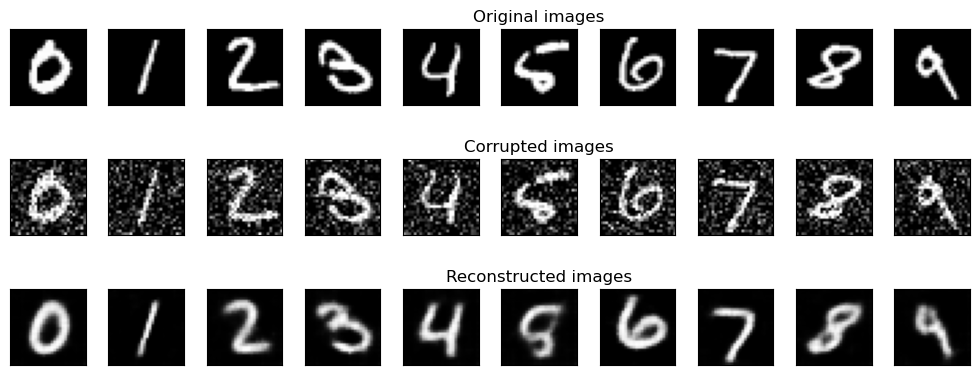

EPOCH 30/30
	 partial train loss (single batch): 0.026806
	 partial train loss (single batch): 0.028107
	 partial train loss (single batch): 0.025587
	 partial train loss (single batch): 0.026900
	 partial train loss (single batch): 0.028977
	 partial train loss (single batch): 0.027108
	 partial train loss (single batch): 0.026728
	 partial train loss (single batch): 0.027748
	 partial train loss (single batch): 0.027459
	 partial train loss (single batch): 0.026143
	 partial train loss (single batch): 0.029071
	 partial train loss (single batch): 0.026955
	 partial train loss (single batch): 0.026296
	 partial train loss (single batch): 0.025307
	 partial train loss (single batch): 0.025657
	 partial train loss (single batch): 0.026644
	 partial train loss (single batch): 0.026073
	 partial train loss (single batch): 0.027256
	 partial train loss (single batch): 0.026340
	 partial train loss (single batch): 0.027137
	 partial train loss (single batch): 0.026858
	 partial train loss (

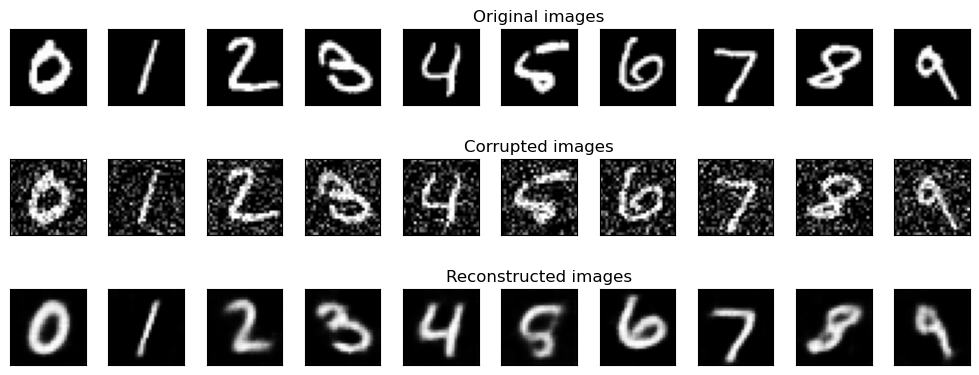

In [13]:
noise_factor = 0.3
num_epochs = 30
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
	print('EPOCH %d/%d' % (epoch + 1, num_epochs))
	### Training (use the training function)
	train_loss=train_epoch_den(
		encoder=encoder,
		decoder=decoder,
		device=device,
		dataloader=train_loader,
		loss_fn=loss_fn,
		optimizer=optim,noise_factor=noise_factor)
	### Validation (use the testing function)
	val_loss = test_epoch_den(
		encoder=encoder,
		decoder=decoder,
		device=device,
		dataloader=valid_loader,
		loss_fn=loss_fn,noise_factor=noise_factor)
	# Print Validationloss
	history_da['train_loss'].append(train_loss)
	history_da['val_loss'].append(val_loss)
	print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
	plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)

In [17]:
test_loader

In [15]:
def show_image(img):
	npimg = img.numpy()
	plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
	# calculate mean and std of latent code, generated takining in test images as inputs
	images, labels = next(iter(test_loader))
	images = images.to(device)
	latent = encoder(images)
	latent = latent.cpu()

	mean = latent.mean(dim=0)
	print(mean)
	std = (latent - mean).pow(2).mean(dim=0).sqrt()
	print(std)

	# sample latent vectors from the normal distribution
	latent = torch.randn(128, d)*std + mean

	# reconstruct images from the random latent vectors
	latent = latent.to(device)
	img_recon = decoder(latent)
	img_recon = img_recon.cpu()

	fig, ax = plt.subplots(figsize=(20, 8.5))
	show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
	plt.show()


AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

In [ ]:
encoded_samples = []
for sample in tqdm(test_dataset):
	img = sample[0].unsqueeze(0).to(device)
	label = sample[1]
	# Encode image
	encoder.eval()
	with torch.no_grad():
	encoded_img = encoder(img)
	# Append to list
	encoded_img = encoded_img.flatten().cpu().numpy()
	encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
	encoded_sample['label'] = label
	encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

In [ ]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',
		   color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
				 color=encoded_samples.label.astype(str),
				 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()